# Importações

In [1]:
import time

import torch
from torch import nn

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM,Dense,GRU

import matplotlib.pyplot as plt
import seaborn as sns

#!pip install plotly --upgrade
import plotly.graph_objects as go


# Carregando/Tratando Dados

In [2]:
bicicletas_dados = pd.read_csv("https://raw.githubusercontent.com/Edgar-Barroso/Rede-Neural-Bike/main/bicicletas.csv")

In [3]:
bicicletas_dados

,datas,contagem,temperatura,sensacao,umidade,vel_vento,clima,feriado,final_ds,estacao
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


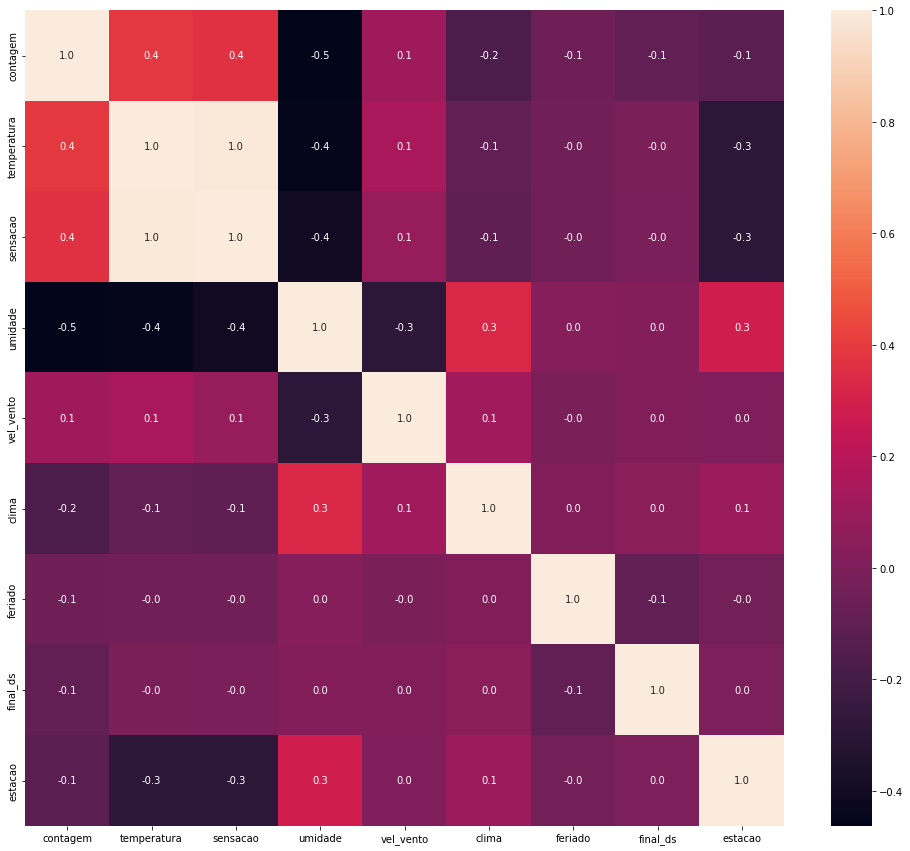

In [4]:
matriz_correlacao = bicicletas_dados.corr()
plt.figure(figsize = (17, 15))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".1f")

In [5]:
bicicletas_dados.isnull().sum()

datas          0
contagem       0
temperatura    0
sensacao       0
umidade        0
vel_vento      0
clima          0
feriado        0
final_ds       0
estacao        0
dtype: int64

In [6]:
bicicletas_dados['datas'] = pd.to_datetime(bicicletas_dados['datas'])

(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]), <a list of 9 Text major ticklabel objects>)

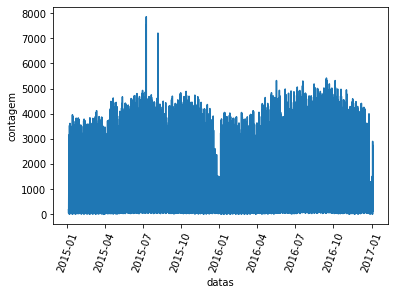

In [7]:
sns.lineplot(x='datas',y='contagem',data = bicicletas_dados);
plt.xticks(rotation=70)

(array([735599., 735689., 735780., 735872., 735964., 736055., 736146.,
        736238., 736330.]), <a list of 9 Text major ticklabel objects>)

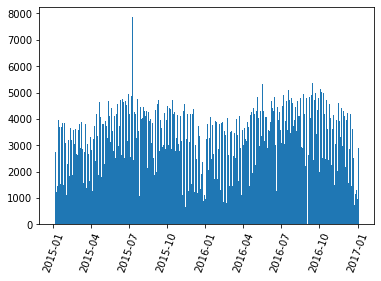

In [8]:
plt.bar(x=bicicletas_dados['datas'].values,height=bicicletas_dados['contagem'].values,)
plt.xticks(rotation=70)

In [9]:
y_= bicicletas_dados['contagem'].values

In [10]:
scaler = StandardScaler()
y_ = scaler.fit_transform(np.reshape(y_,(len(y_),1)))

In [11]:
def voltar_atras(y,n_atras):
  y=list(np.reshape(y,(len(y),)))
  x=[]
  for n,val in enumerate(y):
    if n>=n_atras:
      x.append(y[n-n_atras:n])
  x=np.array(x)
  y=np.array(y[n_atras:])
  return x,y

In [12]:
x,y = voltar_atras(y_,10)

# Separando Treino e Teste

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.20,random_state=0,shuffle=True)
y_test = scaler.inverse_transform(np.reshape(y_test,(len(y_test),1)))

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(13923, 10)
(13923,)
(3481, 10)
(3481, 1)


# Sklearn

## SVR

In [ ]:
svr = SVR()
svr.fit(x_train,y_train)

SVR()

In [ ]:
predicoes = svr.predict(x_test)
predicoes = scaler.inverse_transform(np.reshape(predicoes,(len(predicoes),1)))

In [ ]:
print(abs(predicoes-y_test).mean())

119.82709928175724


## MLP

In [ ]:
mlp = MLPRegressor()
mlp.fit(x_train,y_train)

MLPRegressor()

In [ ]:
predicoes = mlp.predict(x_test)
predicoes = scaler.inverse_transform(np.reshape(predicoes,(len(predicoes),1)))


In [ ]:
print(abs(predicoes-y_test).mean())

112.1265897907239


# Keras

## MLP

In [ ]:
mlp = Sequential()
mlp.add(Dense(128, input_dim=10, kernel_initializer='random_uniform', activation='relu',use_bias=False))
mlp.add(Dense(1, kernel_initializer='random_uniform', activation='linear',use_bias=False))
mlp.compile(loss='mean_squared_error',optimizer='adam')
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dense_1 (Dense)             (None, 1)                 128       
                                                                 
Total params: 1,408
Trainable params: 1,408
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_test = scaler.transform(np.reshape(y_test,(len(y_test),1)))
resultado = mlp.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=200)
y_test = scaler.inverse_transform(np.reshape(y_test,(len(y_test),1)))

Epoch 1/200
436/436 [==============================] - 2s 3ms/step - loss: 0.2909 - val_loss: 0.1174
Epoch 2/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0843 - val_loss: 0.0675
Epoch 3/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0592 - val_loss: 0.0575
Epoch 4/200
436/436 [==============================] - 2s 4ms/step - loss: 0.0530 - val_loss: 0.0513
Epoch 5/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0504 - val_loss: 0.0498
Epoch 6/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0481 - val_loss: 0.0507
Epoch 7/200
436/436 [==============================] - 2s 4ms/step - loss: 0.0475 - val_loss: 0.0460
Epoch 8/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0465 - val_loss: 0.0455
Epoch 9/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0449 - val_loss: 0.0446
Epoch 10/200
436/436 [==============================] - 1s 2ms/step - loss: 0.0449 - val_lo

In [ ]:
predicoes = mlp.predict(x_test)

In [ ]:
predicoes = scaler.inverse_transform(np.reshape(predicoes,(len(predicoes),1)))

In [ ]:
print(abs(predicoes-y_test).mean())

140.26101553060394


## RNN

In [ ]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
recorrente = Sequential()
#recorrente.add(LSTM(128,input_shape=(x_train.shape[1],x_train.shape[2])))#LSTM ou GRU
#recorrente.add(Dense(units=1))
recorrente.add(GRU(128,input_shape=(x_train.shape[1],x_train.shape[2])))#LSTM ou GRU
recorrente.add(Dense(units=1))

In [ ]:
recorrente.compile(loss='mean_squared_error',optimizer='RMSProp')

In [ ]:
recorrente.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               50304     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 50,433
Trainable params: 50,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_test = scaler.transform(np.reshape(y_test,(len(y_test),1)))
resultado = recorrente.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20)
y_test = scaler.inverse_transform(np.reshape(y_test,(len(y_test),1)))

Epoch 1/20
436/436 [==============================] - 7s 16ms/step - loss: 0.0412 - val_loss: 2.0360
Epoch 2/20
436/436 [==============================] - 8s 19ms/step - loss: 0.0374 - val_loss: 2.2325
Epoch 3/20
436/436 [==============================] - 6s 14ms/step - loss: 0.0354 - val_loss: 2.0375
Epoch 4/20
436/436 [==============================] - 6s 13ms/step - loss: 0.0341 - val_loss: 2.1207
Epoch 5/20
436/436 [==============================] - 6s 13ms/step - loss: 0.0328 - val_loss: 2.1288
Epoch 6/20
436/436 [==============================] - 6s 13ms/step - loss: 0.0316 - val_loss: 2.1861
Epoch 7/20
436/436 [==============================] - 6s 14ms/step - loss: 0.0313 - val_loss: 2.1976
Epoch 8/20
436/436 [==============================] - 6s 14ms/step - loss: 0.0299 - val_loss: 2.0984
Epoch 9/20
436/436 [==============================] - 6s 14ms/step - loss: 0.0296 - val_loss: 2.2440
Epoch 10/20
436/436 [==============================] - 6s 14ms/step - loss: 0.0290 - val_lo

In [ ]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1]))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1]))

In [ ]:
predicoes = recorrente.predict(x_test)

In [ ]:
predicoes = scaler.inverse_transform(np.reshape(predicoes,(len(predicoes),1)))
y_test = scaler.inverse_transform(np.reshape(y_test,(len(y_test),1)))

In [ ]:
print(abs(predicoes-y_test).mean())

118.72593267914432


# Pytorch

## Hiperparâmetros

In [21]:
args = {
    'epoch_num': 500,     # Número de épocas.
    'lr': 1e-4,           # Taxa de aprendizado.
    'weight_decay': 5e-4, # Penalidade L1 (Regularização).
    'batch_size': 50,     # Tamanho do batch.
}
args['device'] = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## DataLoader Custom


In [22]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.20,random_state=0,shuffle=True)
y_test = scaler.inverse_transform(np.reshape(y_test,(len(y_test),1)))
y_train = scaler.inverse_transform(np.reshape(y_train,(len(y_train),1)))

In [23]:
x_train = torch.from_numpy(x_train).float().to(args['device'])
y_train = torch.from_numpy(y_train).float().to(args['device'])
x_test  = torch.from_numpy(x_test).float().to(args['device'])
y_test  = torch.from_numpy(y_test).float().to(args['device'])

In [24]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self,x, y):
        self.dado = x
        self.rotulo = y

    def __len__(self):
        return len(self.rotulo)

    def __getitem__(self, idx):
        dado = self.dado[idx]
        rotulo = self.rotulo[idx]
        return dado,rotulo

In [25]:
train_set = CustomDataset(x_train,y_train)
test_set = CustomDataset(x_test,y_test)

In [26]:
train_loader = DataLoader(train_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True)

test_loader = DataLoader(test_set, 
                          batch_size=args['batch_size'], 
                          shuffle=True)

## MLP

### Rede Neural

In [37]:
class MLP(nn.Module):
  def __init__(self,tam_entrada,tam_hidden,tam_saida):
    super(MLP,self).__init__()
    self.layer0 = nn.Linear(tam_entrada,tam_hidden)
    self.ativ0 = nn.ReLU()
    self.layer1 = nn.Linear(tam_hidden,tam_saida)
  def forward(self,X):
    saida = self.layer1(self.ativ0(self.layer0(X)))
    return saida
modelo = MLP(10,128,1).to(args['device'])

In [38]:
criterion = nn.L1Loss().to(args['device'])
optimizer = torch.optim.Adam(modelo.parameters(),weight_decay=1e-4)

### funcs

In [39]:
def train(train_loader, net, epoch):

  # Training mode
  net.train()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  for batch in train_loader:
    
    dado, rotulo = batch
    
    # Cast do dado na GPU
    dado = dado.to(args['device'])
    rotulo = rotulo.to(args['device'])
    
    # Forward
    ypred = net(dado)
    loss = criterion(ypred, rotulo)
    epoch_loss.append(loss.cpu().data)

    _, pred = torch.max(ypred, axis=1)
    pred_list.append(pred.cpu().numpy())
    rotulo_list.append(rotulo.cpu().numpy())
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
  epoch_loss = np.asarray(epoch_loss)
  
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  
  acc = 0
  
  end = time.time()
  print('\033[0;30;44m#################### Train #####################\033[m')
  print('\033[1;33;44mLoss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f' % (epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  return epoch_loss.mean()
    

In [40]:
def validate(test_loader, net, epoch):

  # Evaluation mode
  net.eval()
  
  start = time.time()
  
  epoch_loss  = []
  pred_list, rotulo_list = [], []
  with torch.no_grad(): 
    for batch in test_loader:

      dado, rotulo = batch

      # Cast do dado na GPU
      dado = dado.to(args['device'])
      rotulo = rotulo.to(args['device'])

      # Forward
      ypred = net(dado)
      loss = criterion(ypred, rotulo)
      epoch_loss.append(loss.cpu().data)

      _, pred = torch.max(ypred, axis=1)
      pred_list.append(pred.cpu().numpy())
      rotulo_list.append(rotulo.cpu().numpy())

  epoch_loss = np.asarray(epoch_loss)
  pred_list  = np.asarray(pred_list).ravel()
  rotulo_list  = np.asarray(rotulo_list).ravel()

  acc = 0
  
  end = time.time()
  print('\033[0;30;41m################### Validade ###################\033[m')
  print('\033[1;33;41mLoss: %.4f +/- %.4f, Acc: %.2f, Time: %.2f\n' % (epoch_loss.mean(), epoch_loss.std(), acc*100, end-start))
  
  return epoch_loss.mean()
    

### Treino/Validacao


In [41]:
train_losses, test_losses = [], []
epoch_s = 0
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)    

In [49]:
for epoch in range(args['epoch_num']):
  epoch_s += 1
  print('\033[1;33;42m'+(20*'_')+f'EPOCH [{epoch_s}]'+(20*'_')+'\033[m')
  # Train
  train_losses.append(train(train_loader, modelo, epoch))
  
  # Validate
  test_losses.append(validate(test_loader, modelo, epoch))


____________________EPOCH [1501]____________________
#################### Train #####################
Loss: 118.4794 +/- 25.7845, Acc: 0.00, Time: 0.46
################### Validade ###################
Loss: 121.7375 +/- 23.4079, Acc: 0.00, Time: 0.04

____________________EPOCH [1502]____________________
#################### Train #####################
Loss: 118.2758 +/- 28.3091, Acc: 0.00, Time: 0.45
################### Validade ###################
Loss: 122.0827 +/- 24.1819, Acc: 0.00, Time: 0.04

____________________EPOCH [1503]____________________
#################### Train #####################
Loss: 118.2949 +/- 26.5779, Acc: 0.00, Time: 0.45
################### Validade ###################
Loss: 122.1845 +/- 23.5554, Acc: 0.00, Time: 0.04

____________________EPOCH [1504]____________________
#################### Train #####################
Loss: 118.5658 +/- 27.9727, Acc: 0.00, Time: 0.45
################### Validade ###################
Loss: 121.6955 +/- 27.0766, Acc: 0.00, Time

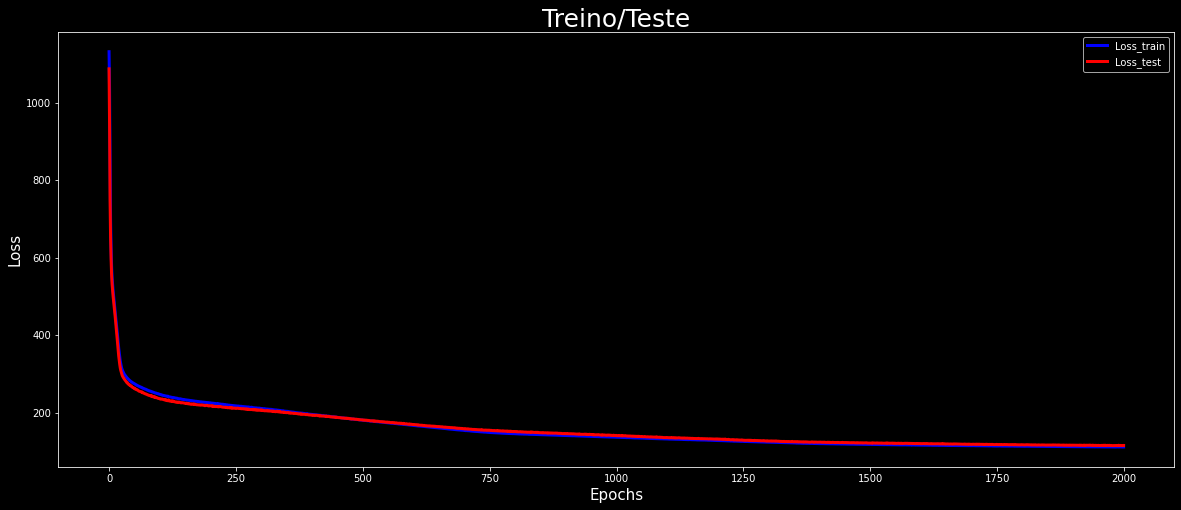

In [50]:
with plt.style.context('dark_background') as _:
  plt.figure(figsize=(20,8))
  plt.plot(range(epoch_s),train_losses, linewidth=3.0,color ='blue')
  plt.plot(range(epoch_s),test_losses, linewidth=3.0,color = 'red')
  plt.title('Treino/Teste',fontsize=25)
  plt.xlabel('Epochs', fontsize=15)
  plt.ylabel('Loss', fontsize=15)
  plt.legend(('Loss_train', 'Loss_test'))
  plt.show()

## RNN

### Rede Neural

In [256]:
class RNN(nn.Module):
  def __init__(self,tam_entrada,tam_hidden,tam_saida):
    super(RNN,self).__init__()
    self.tam_hidden = tam_hidden
    self.rnn = nn.GRU(tam_entrada,tam_hidden)
    self.saida = nn.Linear(tam_hidden,tam_saida)

  def forward(self,dados):
    dados=dados.unsqueeze(-1).permute(1,0,2)
    hidden = torch.zeros(1,dados.shape[1],self.tam_hidden).to(args['device'])
    saida,hidden = self.rnn(dados,hidden)
    saida = self.saida(saida[-1])
    return saida

modelo = RNN(1,32,1).to(args['device'])

In [257]:
criterion = nn.L1Loss().to(args['device'])
optimizer = torch.optim.Adam(modelo.parameters(),lr=args['lr'],weight_decay=args['weight_decay'])

### Treino/Validacao

In [258]:
train_losses, test_losses = [], []
epoch_s = 0
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)    

In [1]:
for epoch in range(args['epoch_num']):
  epoch_s += 1
  print('\033[1;33;42m'+(20*'_')+f'EPOCH [{epoch_s}]'+(20*'_')+'\033[m')
  # Train
  train_losses.append(train(train_loader, modelo, epoch))
  
  # Validate
  test_losses.append(validate(test_loader, modelo, epoch))

NameError: ignored

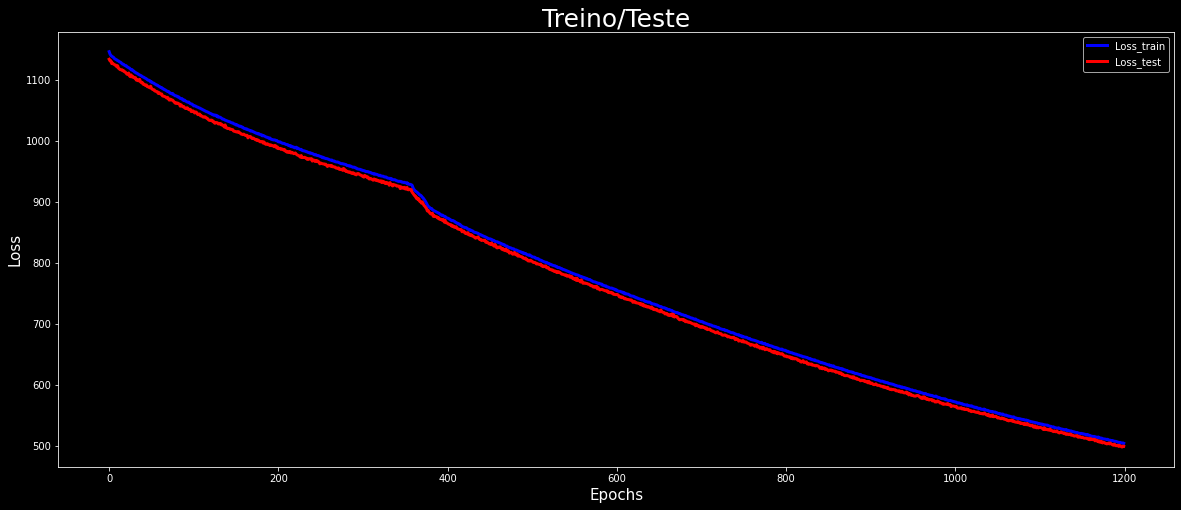

In [265]:
with plt.style.context('dark_background') as _:
  plt.figure(figsize=(20,8))
  plt.plot(range(epoch_s),train_losses, linewidth=3.0,color ='blue')
  plt.plot(range(epoch_s),test_losses, linewidth=3.0,color = 'red')
  plt.title('Treino/Teste',fontsize=25)
  plt.xlabel('Epochs', fontsize=15)
  plt.ylabel('Loss', fontsize=15)
  plt.legend(('Loss_train', 'Loss_test'))
  plt.show()